In [1]:
import os
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist, euclidean, cosine

from glob import glob

from model import vggvox_model
from wav_reader import get_fft_spectrum
import constants as c

Using TensorFlow backend.


In [2]:
model = vggvox_model()
model.load_weights(c.WEIGHTS_FILE)
model.summary()

Model: "VGGVox"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 512, None, 1)      0         
_________________________________________________________________
pad1 (ZeroPadding2D)         (None, 514, None, 1)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 254, None, 96)     4800      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 254, None, 96)     384       
_________________________________________________________________
relu1 (Activation)           (None, 254, None, 96)     0         
_________________________________________________________________
mpool1 (MaxPooling2D)        (None, 126, None, 96)     0         
_________________________________________________________________
pad2 (ZeroPadding2D)         (None, 128, None, 96)     0    

In [3]:
def build_buckets(max_sec, step_sec, frame_step):
	buckets = {}
	frames_per_sec = int(1/frame_step)
	end_frame = int(max_sec*frames_per_sec)
	step_frame = int(step_sec*frames_per_sec)
	for i in range(0, end_frame+1, step_frame):
		s = i
		s = np.floor((s-7+2)/2) + 1  # conv1
		s = np.floor((s-3)/2) + 1  # mpool1
		s = np.floor((s-5+2)/2) + 1  # conv2
		s = np.floor((s-3)/2) + 1  # mpool2
		s = np.floor((s-3+2)/1) + 1  # conv3
		s = np.floor((s-3+2)/1) + 1  # conv4
		s = np.floor((s-3+2)/1) + 1  # conv5
		s = np.floor((s-3)/2) + 1  # mpool5
		s = np.floor((s-1)/1) + 1  # fc6
		if s > 0:
			buckets[i] = int(s)
	return buckets

In [4]:
def get_embeddings_from_list_file(model, list_file, max_sec):
	buckets = build_buckets(max_sec, c.BUCKET_STEP, c.FRAME_STEP)
	result = pd.read_csv(list_file, delimiter=",")
	result['features'] = result['filename'].apply(lambda x: get_fft_spectrum(x, buckets))
	result['embedding'] = result['features'].apply(lambda x: np.squeeze(model.predict(x.reshape(1,*x.shape,1))))
	return result[['filename','speaker','embedding']]

In [5]:
# print("Processing enroll samples....")
# enroll_result = get_embeddings_from_list_file(model, c.ENROLL_LIST_FILE, c.MAX_SEC)
# enroll_embs = np.array([emb.tolist() for emb in enroll_result['embedding']])
# speakers = enroll_result['speaker']

# print("Processing test samples....")
# test_result = get_embeddings_from_list_file(model, c.TEST_LIST_FILE, c.MAX_SEC)
# test_embs = np.array([emb.tolist() for emb in test_result['embedding']])

# print("Comparing test samples against enroll samples....")
# distances = pd.DataFrame(cdist(test_embs, enroll_embs, metric=c.COST_METRIC), columns=speakers)

# scores = pd.read_csv(c.TEST_LIST_FILE, delimiter=",",header=0,names=['test_file','test_speaker'])
# scores = pd.concat([scores, distances],axis=1)
# scores['result'] = scores[speakers].idxmin(axis=1)
# scores['correct'] = (scores['result'] == scores['test_speaker'])*1. # bool to int

# print("Writing outputs to [{}]....".format(c.RESULT_FILE))
# result_dir = os.path.dirname(c.RESULT_FILE)
# if not os.path.exists(result_dir):
#     os.makedirs(result_dir)
# with open(c.RESULT_FILE, 'w') as f:
#     scores.to_csv(f, index=False)

In [6]:
# scores

In [322]:
# make TIMIT-sample dataset
from glob import glob
from pathlib import Path

from pandas import DataFrame

EXCLUDE_FILES = ["sa1.wav", "sa2.wav"]

trainIDList = []
trainFileList = []
testIDlist = []
testFileList = []

speakerDirectories = glob("/home/ratthapon/TIMIT/timit/train/*/")

for speakerDirectory in speakerDirectories:
    speakerID = Path(speakerDirectory).name
    print("Speaker:", speakerID)
    
    wavFiles = glob(speakerDirectory + "/*.wav")
    nWavFile = len(wavFiles)
    
    fileIndex = 0
    for wavFile in wavFiles:
        if Path(wavFile).name in EXCLUDE_FILES:
            # skip this files
            continue
            
        if fileIndex < (nWavFile-2)/2:
            trainIDList += [speakerID]
            trainFileList += [wavFile]
            print("    Train:", Path(wavFile).name)
            
        if fileIndex >= (nWavFile-2)/2:
            testIDlist += [speakerID]
            testFileList += [wavFile]
            print("    Test:", Path(wavFile).name)
            
        fileIndex += 1
        
trainingSet = DataFrame({
    "speaker": trainIDList,
    "filename": trainFileList
}) 
testingSet = DataFrame({
    "speaker": testIDlist,
    "filename": testFileList
})

print("Exporting enroll list to CSV:", "cfg/enroll_list_timit.csv")
trainingSet.to_csv("cfg/enroll_list_timit.csv", columns = ["filename", "speaker"], index = False)

print("Exporting test list to CSV:", "cfg/test_list_timit.csv")
testingSet.to_csv("cfg/test_list_timit.csv", columns = ["filename", "speaker"], index = False)
        

Speaker: dr7-madd0
    Train: si538.wav
    Train: sx268.wav
    Train: sx448.wav
    Train: sx88.wav
    Test: si1295.wav
    Test: si1798.wav
    Test: sx358.wav
    Test: sx178.wav
Speaker: dr8-fbcg1
    Train: sx82.wav
    Train: sx262.wav
    Train: sx352.wav
    Train: sx442.wav
    Test: sx172.wav
    Test: si2242.wav
    Test: si982.wav
    Test: si1612.wav
Speaker: dr6-mbma1
    Train: sx414.wav
    Train: sx144.wav
    Train: sx234.wav
    Train: si2214.wav
    Test: sx324.wav
    Test: si2207.wav
    Test: si954.wav
    Test: sx54.wav
Speaker: dr1-mcpm0
    Train: sx114.wav
    Train: sx294.wav
    Train: sx204.wav
    Train: si1194.wav
    Test: sx24.wav
    Test: si1824.wav
    Test: sx384.wav
    Test: si564.wav
Speaker: dr3-falk0
    Train: sx6.wav
    Train: sx186.wav
    Train: si1086.wav
    Train: sx366.wav
    Test: sx96.wav
    Test: si658.wav
    Test: sx276.wav
    Test: si456.wav
Speaker: dr6-fapb0
    Train: si1063.wav
    Train: si1693.wav
    Train: sx73.wav


In [323]:
TIMIT_ENROLL_LIST = "cfg/enroll_list_timit.csv"
TIMIT_TEST_LIST = "cfg/test_list_timit.csv"
TIMIT_RESULT = "res/test_list_timit.csv"

print("Processing enroll samples....")
enroll_result = get_embeddings_from_list_file(model, TIMIT_ENROLL_LIST, c.MAX_SEC)
enroll_embs = np.array([emb.tolist() for emb in enroll_result['embedding']])
speakers = enroll_result['speaker']

print("Processing test samples....")
test_result = get_embeddings_from_list_file(model, TIMIT_TEST_LIST, c.MAX_SEC)
test_embs = np.array([emb.tolist() for emb in test_result['embedding']])

# print("Comparing test samples against enroll samples....")
# distances = pd.DataFrame(cdist(test_embs, enroll_embs, metric=c.COST_METRIC), columns=speakers)

# scores = pd.read_csv(TIMIT_TEST_LIST, delimiter=",",header=0,names=['test_file','test_speaker'])
# scores = pd.concat([scores, distances],axis=1)
# scores['result'] = scores[speakers].idxmin(axis=1)
# scores['correct'] = (scores['result'] == scores['test_speaker'])*1. # bool to int

# print("Writing outputs to [{}]....".format(TIMIT_RESULT))
# result_dir = os.path.dirname(TIMIT_RESULT)
# if not os.path.exists(result_dir):
#     os.makedirs(result_dir)
# with open(TIMIT_RESULT, 'w') as f:
#     scores.to_csv(f, index=False)

Processing enroll samples....
Processing test samples....


In [90]:
import itertools
import sys

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm

from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y, clf):
    # display predicted scores by the model as a contour plot
#     x = np.linspace(-18, 10)
#     y = np.linspace(-17, 9.)
#     X, Y = np.meshgrid(x, y)
#     XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -clf.score_samples(X)
    print(Z.shape)
#     Z = Z.reshape(X.shape)
    CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))
    CB = plt.colorbar(CS, shrink=0.8, extend='both')
    plt.scatter(X, Y, 0.8)
    plt.title('Negative log-likelihood traine using GMM')
    plt.axis('tight')
    plt.show()

#     plt.xlim(-9., 5.)
#     plt.ylim(-3., 6.)
#     plt.xticks(())
#     plt.yticks(())
#     plt.title(title)

In [91]:
print(np.max(gmm.predict(enroll_embs)))
print(np.min(gmm.predict(enroll_embs)))
print(np.max(enroll_embs))
print(np.min(enroll_embs))

print(enroll_embs.shape)


4
0
0.07083636522293091
-0.09148954600095749
(64, 1024)


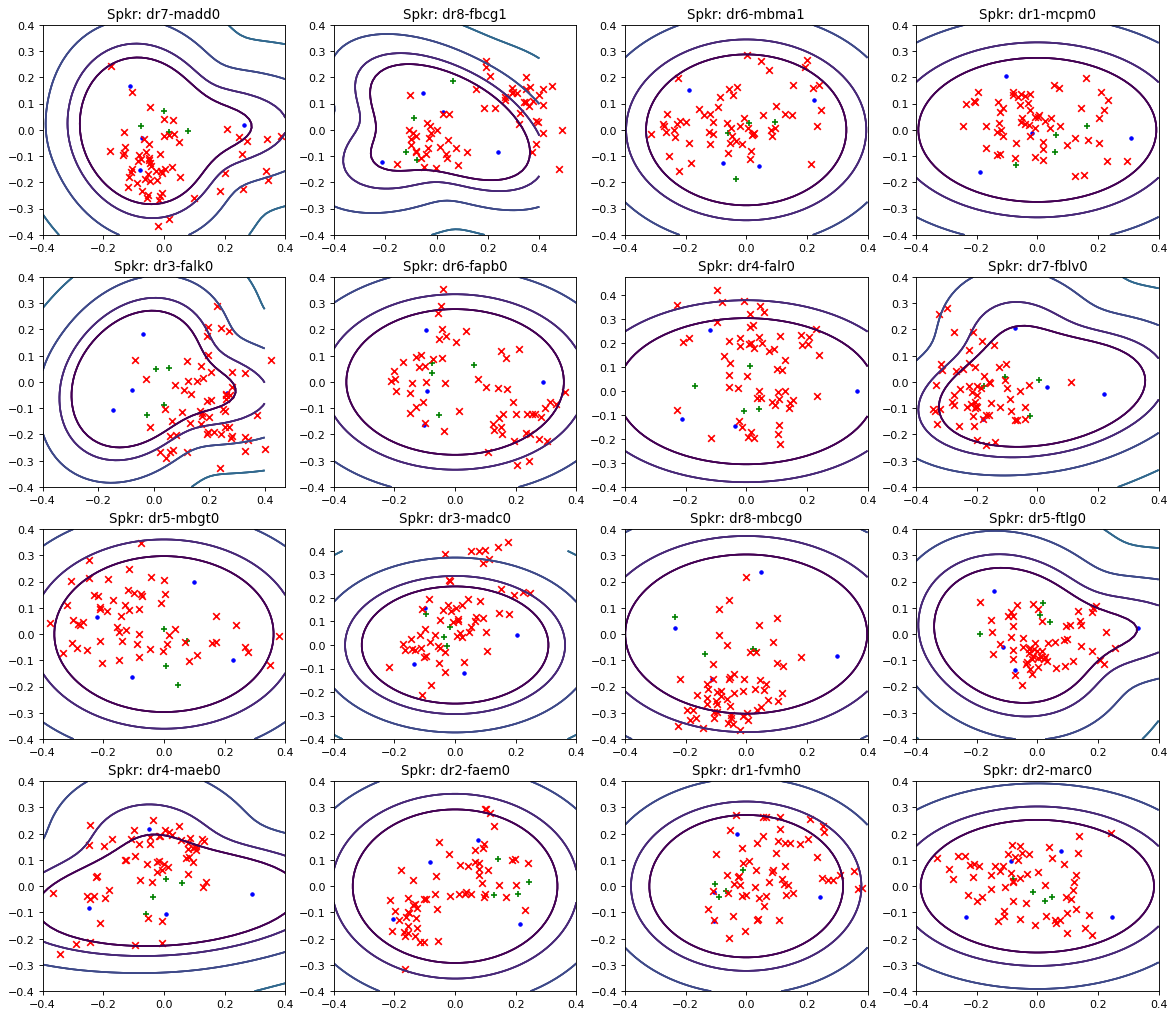

In [324]:
import warnings
warnings.filterwarnings('ignore')

import itertools
from math import sqrt

import numpy as np
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

def projectProb2D(embs):
    pca = PCA(n_components = 2).fit(embs)
    return pca

def visualizeCompressedSpeechComponents(embs, mixtureModel, nFigs, n, marker = ".", c = "blue"):
    # display predicted scores by the model as a contour plot
    deviation = 0.4
    x = np.linspace(-deviation, deviation)
    y = np.linspace(-deviation, deviation)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = - mixtureModel.score_samples(XX)
    Z = Z.reshape(X.shape)
    
    plt.subplot(nFigs, nFigs, n)
    CS = plt.contour(X, Y, Z, norm = LogNorm(vmin=1.0, vmax=1000.0),
                     levels = np.logspace(0, 3, 10))
#     CB = plt.colorbar(CS, shrink=0.8, extend='both')
    plt.scatter(embs[:, 0], embs[:, 1], marker = marker, c = c)
    pass

planes = dict()
models = dict()
speakers = enroll_result['speaker'].unique()
nFigs = sqrt(len(speakers))

for i, j in itertools.product(range(1, int(nFigs) + 1), range(1, int(nFigs) + 1)):
    speakerIdx = j + ((i-1)*4) - 1
    speaker = speakers[speakerIdx]
    embs = np.array([emb.tolist() for emb in enroll_result[enroll_result["speaker"] == speaker]["embedding"]])
    
    pca = PCA(n_components = 2).fit(embs)
    compressedEmbs = pca.transform(embs)
    planes[speaker] = pca
    
    clf = BayesianGaussianMixture(n_components = 4, covariance_type = 'full')
    clf.fit(compressedEmbs)
    models[speaker] = clf
    
    # Training samples
    visualizeCompressedSpeechComponents(compressedEmbs, clf, nFigs, speakerIdx + 1)    
    
    # Positive prediction
    embs = np.array([emb.tolist() for emb in test_result[test_result["speaker"] == speaker]["embedding"]])
    compressedEmbs = pca.transform(embs)
    visualizeCompressedSpeechComponents(compressedEmbs, clf, nFigs, speakerIdx + 1, marker = "+", c = "green")
    
    # Negative prediction
    embs = np.array([emb.tolist() for emb in test_result[test_result["speaker"] != speaker]["embedding"]])
    compressedEmbs = pca.transform(embs)
    visualizeCompressedSpeechComponents(compressedEmbs, clf, nFigs, speakerIdx + 1, marker = "x", c = "red")
    
    plt.title("Spkr: " + speaker)

plt.show()
    
    

[[-0.02268564 -0.01080924  0.00768165 ... -0.04658406 -0.02638694
   0.04483725]
 [-0.01866809  0.08136909 -0.007707   ... -0.00252123  0.04709466
   0.03372785]]


ValueError: too many values to unpack (expected 2)

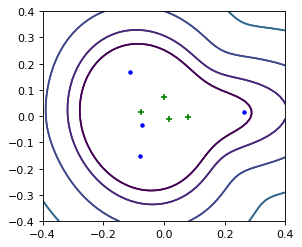

In [398]:
import warnings
warnings.filterwarnings('ignore')

import itertools
from math import sqrt

import numpy as np
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

def plotHyperplane(pca):
    # get the separating hyperplane
    w = pca.components_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-1.5, 1.5)  # make sure the line is long enough
    yy = a * xx - (pca.mean_[0]) / w[1]
    
    p = pca.components_
    centroid = pca.mean_
#     segments = np.arange(-512, 512)[:, np.newaxis] * p
#     (centroid + segments).T
    plt.plot(xx, yy)

def draw_vector(v0, v1, ax = None):
    ax = ax or plt.gca()
    arrowprops = dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

def projectProb2D(embs):
    pca = PCA(n_components = 2).fit(embs)
    return pca

def visualizeCompressedSpeechComponents(embs, mixtureModel, nFigs, n, marker = ".", c = "blue"):
    # display predicted scores by the model as a contour plot
    deviation = 0.4
    x = np.linspace(-deviation, deviation)
    y = np.linspace(-deviation, deviation)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = - mixtureModel.score_samples(XX)
    Z = Z.reshape(X.shape)
    
    plt.subplot(nFigs, nFigs, n)
    CS = plt.contour(X, Y, Z, norm = LogNorm(vmin=1.0, vmax=1000.0),
                     levels = np.logspace(0, 3, 10))
#     CB = plt.colorbar(CS, shrink=0.8, extend='both')
    plt.scatter(embs[:, 0], embs[:, 1], marker = marker, c = c)
    pass

# planes = dict()
# models = dict()
speakers = enroll_result['speaker'].unique()
nFigs = sqrt(len(speakers))

for i, j in itertools.product(range(1, int(nFigs) + 1), range(1, int(nFigs) + 1)):
    speakerIdx = j + ((i-1)*4) - 1
    speaker = speakers[speakerIdx]
    embs = np.array([emb.tolist() for emb in enroll_result[enroll_result["speaker"] == speaker]["embedding"]])
    
    pca = planes[speaker] 
    
    clf = models[speaker]
    
    # Training samples
    compressedEmbs = pca.transform(embs)
    visualizeCompressedSpeechComponents(compressedEmbs, clf, nFigs, speakerIdx + 1)    
    
    # Positive prediction
    embs = np.array([emb.tolist() for emb in test_result[test_result["speaker"] == speaker]["embedding"]])
    compressedEmbs = pca.transform(embs)
    visualizeCompressedSpeechComponents(compressedEmbs, clf, nFigs, speakerIdx + 1, marker = "+", c = "green")
    
    # Negative prediction
    embs = np.array([emb.tolist() for emb in test_result[test_result["speaker"] != speaker]["embedding"]])
    compressedEmbs = pca.transform(embs)
#     visualizeCompressedSpeechComponents(compressedEmbs, clf, nFigs, speakerIdx + 1, marker = "x", c = "red")
#     plotHyperplane(pca)
    print(pca.components_)
    for length, vector in zip(pca.explained_variance_, pca.components_):
        v = vector * 3 * np.sqrt(length)
        draw_vector(pca.mean_, pca.mean_ + v)
    
    plt.title("Spkr: " + speaker)

plt.show()
    
    

In [389]:
for speaker in speakers:
    pca = planes[speaker]
    print(pca.mean_)

[-0.01313051  0.02999419 -0.00106901 ... -0.04097077 -0.00139704
 -0.00175083]
[ 3.89005989e-03 -7.93817453e-03  1.58250474e-02 ...  2.44261322e-02
 -5.76819293e-05  4.14863388e-03]
[ 0.01176101  0.01341804 -0.0015206  ... -0.01723856  0.02894617
  0.01328052]
[-0.01042302 -0.00910116  0.00257355 ... -0.00192613 -0.03975799
 -0.01859211]
[ 0.00263636 -0.00030792  0.02758943 ...  0.02264313 -0.0197883
  0.0070247 ]
[ 0.00702835 -0.02004624  0.02942658 ...  0.0076199  -0.04286558
 -0.03450005]
[ 0.0031983   0.01608304  0.0232901  ...  0.03054189  0.00444502
 -0.00356973]
[ 0.01690282  0.01682998  0.02708986 ...  0.04140013  0.01054304
 -0.00310635]
[-0.00055541  0.01930943 -0.01514759 ... -0.03193777  0.02311086
  0.00578644]
[-0.00790109  0.04287297  0.00339122 ... -0.01835542 -0.00139534
 -0.00137585]
[ 0.00567296  0.02632205 -0.00089314 ... -0.01945628  0.02577417
  0.01716858]
[ 0.0074036   0.00198456  0.01921386 ...  0.03299112 -0.01873658
 -0.01896903]
[-0.00918745  0.00148904  0.0

In [214]:
# Verification using GMM
match = lambda 
for speaker in speakers:
    embs = np.array([emb.tolist() for emb in test_result[test_result["speaker"] == speaker]["embedding"]])
   
    pca = planes[speaker]
    compressedEmbs = pca.transform(embs)
    
    clf = models[speaker]
    print(clf.score(compressedEmbs))
    test_result[test_result["speaker"] == speaker]["likelihood"] = clf.score(compressedEmbs)
#     print(test_result)
    

1.6474860486620244
0.12551357463607857
1.2642829410551393
1.0710209992170052
1.436931836968106
1.258050236632975
0.8744742557376043
1.2966125825901982
1.0301816604077318
1.5840154097428214
0.8628469874471209
0.9379438280283668
1.2882284268089856
-0.41209213498965036
1.573986134051487
1.209528915844797


In [225]:
test_match = lambda dataset: print(dataset["speaker"])
def verifySpeaker(row):
    speaker = row["speaker"]
    embs = np.array([emb.tolist() for emb in row[["embedding"]]])
   
    pca = planes[speaker]
    compressedEmbs = pca.transform(embs)
    
    clf = models[speaker]
    return clf.score(compressedEmbs)
    
test_result["score"] = test_result.apply(verifySpeaker, axis = 1)

In [228]:
test_result.apply(lambda row: print(row["speaker"], row["score"]), axis = 1)

dr7-madd0 1.6300209257154936
dr7-madd0 1.7691133912879333
dr7-madd0 1.6325417836184375
dr7-madd0 1.558268094026234
dr8-fbcg1 1.230357878859647
dr8-fbcg1 -0.37255003550224375
dr8-fbcg1 -0.15778147124201297
dr8-fbcg1 -0.19797207357107624
dr6-mbma1 1.6183402165479654
dr6-mbma1 1.387904349777288
dr6-mbma1 1.5514166219507404
dr6-mbma1 0.49947057594456346
dr1-mcpm0 1.138060638247277
dr1-mcpm0 0.7764667735821297
dr1-mcpm0 1.0060687708338263
dr1-mcpm0 1.3634878142047884
dr3-falk0 1.0365252133333682
dr3-falk0 1.4168053755144392
dr3-falk0 1.6928975288825392
dr3-falk0 1.6014992301420778
dr6-fapb0 0.9963228147200786
dr6-fapb0 1.4051424602528144
dr6-fapb0 1.3518561571726222
dr6-fapb0 1.2788795143863847
dr4-falr0 0.7592216179274552
dr4-falr0 0.9395305440464922
dr4-falr0 0.9468160567622826
dr4-falr0 0.8523288042141871
dr7-fblv0 1.7199679450390124
dr7-fblv0 0.9236500368622583
dr7-fblv0 1.1199377710039928
dr7-fblv0 1.4228945774555295
dr5-mbgt0 1.3129828624214381
dr5-mbgt0 0.36037774681853896
dr5-mbgt0 

0     None
1     None
2     None
3     None
4     None
      ... 
59    None
60    None
61    None
62    None
63    None
Length: 64, dtype: object

In [229]:
test_result["score"].describe()

count    64.000000
mean      1.065563
std       0.635766
min      -1.381079
25%       0.905820
50%       1.158194
75%       1.496734
max       1.947340
Name: score, dtype: float64

In [233]:
attacks = test_result[["speaker", "embedding"]]

def verificationAttack(row):
    enrolled_speaker = row["enrolled_speaker"]
    embs = np.array([emb.tolist() for emb in row[["embedding"]]])
   
    pca = planes[enrolled_speaker]
    compressedEmbs = pca.transform(embs)
    
    clf = models[enrolled_speaker]
    return clf.score(compressedEmbs)

for enrolled_speaker in speakers:
    attacks["enrolled_speaker"] = enrolled_speaker
    attacks[enrolled_speaker] = attacks.apply(verificationAttack, axis = 1)

attacks

,speaker,embedding,enrolled_speaker,dr7-madd0,dr8-fbcg1,dr6-mbma1,dr1-mcpm0,dr3-falk0,dr6-fapb0,dr4-falr0,dr7-fblv0,dr5-mbgt0,dr3-madc0,dr8-mbcg0,dr5-ftlg0,dr4-maeb0,dr2-faem0,dr1-fvmh0,dr2-marc0
0,dr7-madd0,"[-0.025399309, 0.032062694, 0.0043030703, 0.00...",dr2-marc0,1.630021,-3.331126,0.152474,1.384514,-1.550330,-0.902829,-0.888243,0.371848,0.930455,0.467604,0.995364,0.229974,0.111422,-2.610211,-0.150517,0.749038
1,dr7-madd0,"[-0.027206954, 0.029609043, -0.011948302, 0.01...",dr2-marc0,1.769113,-8.221324,-1.084463,0.513748,0.968517,-0.283785,-0.654574,0.608710,0.049004,1.832799,1.116273,1.511290,0.576119,0.093001,-1.664002,1.082197
2,dr7-madd0,"[-0.021918848, 0.029215254, -0.0031658383, 0.0...",dr2-marc0,1.632542,-3.122364,-0.607932,0.859859,-0.518044,0.635994,0.068437,0.031720,0.852682,1.580561,1.179620,1.338354,0.411948,-0.549546,-0.568233,0.866581
3,dr7-madd0,"[-0.019782027, 0.035818685, -0.016655207, -0.0...",dr2-marc0,1.558268,-6.793254,-0.924245,0.803061,0.440616,0.561436,-0.023664,0.217887,0.362886,1.894823,1.097638,1.241668,-0.618212,-0.806138,-1.994233,0.733908
4,dr8-fbcg1,"[0.0064140917, -0.01531937, 0.017321039, -0.01...",dr2-marc0,0.917804,1.230358,-0.241174,1.242273,-2.249080,1.543162,0.759659,-3.338220,-1.904386,1.501861,-0.604826,0.074830,1.253695,-0.707510,0.375794,-0.222406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,dr1-fvmh0,"[0.017426576, -0.0081677865, 0.027277349, 0.01...",dr2-marc0,1.400251,-0.691458,-0.760622,1.143817,-0.088015,1.166406,0.264029,0.464637,-1.252999,1.049283,-0.830471,0.640925,-0.117081,0.741627,1.492203,0.882552
60,dr2-marc0,"[0.00036800798, -0.004190301, -0.016610676, -0...",dr2-marc0,1.758473,-3.124078,0.651205,1.259220,1.088111,-0.771075,1.077656,0.514941,0.774188,1.870822,0.665142,0.021538,0.176095,1.283650,-0.317643,0.938195
61,dr2-marc0,"[-0.0051765065, -0.012795515, 0.0026949563, -0...",dr2-marc0,0.317169,-4.012519,1.070024,1.333966,1.309182,-0.630373,0.908896,-0.319532,0.692734,1.325461,0.476075,1.474521,0.337845,1.059083,0.713182,1.565349
62,dr2-marc0,"[0.012974704, 0.0014481352, -0.0030417584, -0....",dr2-marc0,1.743302,-2.905905,0.297970,1.164298,1.264729,-1.952246,0.967228,-0.194352,0.576208,1.509222,0.790722,-0.311861,0.221848,1.583643,-0.929595,0.943998


In [237]:
clf_result = attacks.drop(columns = ["speaker", "embedding", "enrolled_speaker"]).idxmax(axis = 1)
print(clf_result)

0     dr7-madd0
1     dr3-madc0
2     dr7-madd0
3     dr3-madc0
4     dr6-fapb0
        ...    
59    dr1-fvmh0
60    dr3-madc0
61    dr2-marc0
62    dr7-madd0
63    dr3-madc0
Length: 64, dtype: object


In [240]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(attacks["speaker"], clf_result))

[[4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 2 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 2 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 3 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 1 1 0 0 0]
 [2 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0]
 [2 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 2 1 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 1 2 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0]
 [0 2 0 0 0 1 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 2 0 1 0 0]]


# Speaker Verification using LogisticRegression

In [330]:
import warnings
warnings.filterwarnings('ignore')

import itertools
from math import sqrt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

voicePrints = dict()
speakers = enroll_result['speaker'].unique()

scoreThreshold = 0.5

# Enroll phase
for enrolledSpeaker in speakers:
    embs = np.array([emb.tolist() for emb in enroll_result[enroll_result["speaker"] == enrolledSpeaker]["embedding"]])
    genuieEmbs = np.array([emb.tolist() for emb in test_result[test_result["speaker"] == enrolledSpeaker]["embedding"]])
    attackEmbs = np.array([emb.tolist() for emb in test_result[test_result["speaker"] != enrolledSpeaker]["embedding"]])
    
    voicePrint = embs.mean(axis = 0).reshape((1, embs.shape[1]))
    voicePrints[enrolledSpeaker] = voicePrint
    
    print(voicePrint.shape, genuieEmbs.shape)
    score = 1 - cdist(voicePrint, genuieEmbs)
    reject = 1 - cdist(voicePrint, attackEmbs)
    print(score.mean(), reject.mean(), score.std(), reject.std())
    
    scoreThreshold = score.mean() - score.std()
    

# Verification phase
cosVerification = lambda row: (1 - cdist(voicePrints[row["speaker"]], np.array([row["embedding"]])))[0,0]

test_result["score"] = test_result[["speaker", "embedding"]].apply(cosVerification, axis = 1)
test_result["threshold"] = test_result["score"].mean() - 2*test_result["score"].std()

(1, 1024) (4, 1024)
0.6869559209875689 0.3072600721024728 0.0625875269230683 0.12762645468260633
(1, 1024) (4, 1024)
0.7270014218821221 0.3009965483993183 0.0476117113759549 0.14193936551726835
(1, 1024) (4, 1024)
0.6704958455446689 0.3115935233332945 0.04989291677538873 0.1349621035440676
(1, 1024) (4, 1024)
0.6693385304231558 0.30245295322267524 0.09720802536459378 0.1206458718788303
(1, 1024) (4, 1024)
0.7530196843934647 0.2859213348881483 0.04521624164585528 0.1219823769857876
(1, 1024) (4, 1024)
0.706338716105223 0.33941647106322786 0.02399336176993329 0.1449674684783104
(1, 1024) (4, 1024)
0.6791437452800535 0.33690176024080654 0.014467456770328886 0.17033269913865673
(1, 1024) (4, 1024)
0.7332491154141073 0.28005679033125386 0.039675543447613704 0.15406368226398262
(1, 1024) (4, 1024)
0.6900327178549505 0.28699630458915376 0.08852746468028552 0.144555410766367
(1, 1024) (4, 1024)
0.7352981514240291 0.22279736233616157 0.07767038416257427 0.12160032958354977
(1, 1024) (4, 1024)
0

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 <a list of 16 Text xticklabel objects>)

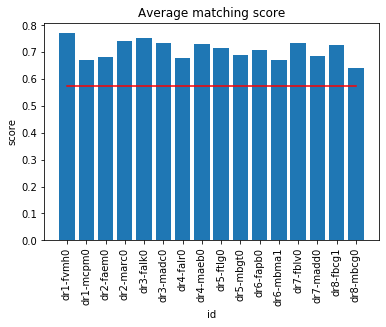

In [383]:
# plt.plot(test_result[["score","threshold"]])
groupByScore = test_result.groupby("speaker", as_index = False).mean()
# groupByScore["speaker"]
plt.bar(height = groupByScore["score"], x = groupByScore["speaker"].values)
plt.plot(groupByScore["threshold"], color = "red")
plt.title("Average matching score")
plt.xlabel("id")
plt.ylabel("score")
plt.xticks(rotation = 90)

In [ ]:
test_result["passed"] = test_result["score"] > test_result["threshold"]
print("threshold", test_result["threshold"].mean())
test_result["score"].describe()

Text(0, 0.5, 'count')

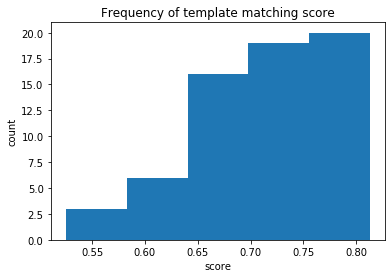

In [337]:
import matplotlib.pyplot as plt

plt.hist(test_result["score"], 5)
plt.title("Frequency of template matching score")
plt.xlabel("score")
plt.ylabel("count")

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture
from sklearn.decomposition import PCA


# n_samples = 300

# # generate random sample, two components
# np.random.seed(0)

# # generate spherical data centered on (20, 20)
# shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# # generate zero centered stretched Gaussian data
# C = np.array([[0., -0.7], [3.5, .7]])
# stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# # concatenate the two datasets into the final training set
# X_train = np.vstack([shifted_gaussian, stretched_gaussian])

speakers = enroll_result['speaker'].unique()

for 
    # fit a Gaussian Mixture Model with two components
    enroll_embs = np.array([emb.tolist() for emb in enroll_result['embedding']])
    viz_plane = PCA(n_components=2).fit(enroll_embs)

    enroll_embs = np.array([emb.tolist() for emb in enroll_result['embedding']])
    X_train = viz_plane.transform(enroll_embs)
    clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
    clf.fit(X_train)

    # display predicted scores by the model as a contour plot
    x = np.linspace(-1., 1.)
    y = np.linspace(-1., 1.)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -clf.score_samples(XX)
    Z = Z.reshape(X.shape)

    CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                     levels=np.logspace(0, 3, 10))
    CB = plt.colorbar(CS, shrink=0.8, extend='both')
    plt.scatter(X_train[:, 0], X_train[:, 1], .8)

    plt.title('Negative log-likelihood predicted by a GMM')
    plt.axis('tight')
    plt.show()


SyntaxError: invalid syntax (<ipython-input-153-8979c3d2aadc>, line 25)

/home/ratthapon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Log scale: values of z <= 0 have been masked
  from ipykernel import kernelapp as app


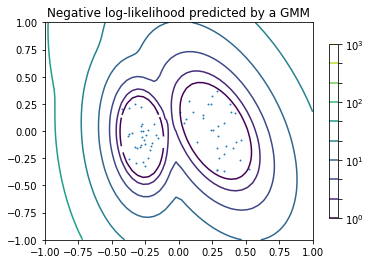

In [119]:
# fit a Gaussian Mixture Model with two components
X_test = viz_plane.transform(test_embs)
clf2 = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf2.fit(X_test)

# display predicted scores by the model as a contour plot
x = np.linspace(-1., 1.)
y = np.linspace(-1., 1.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf2.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_test[:, 0], X_test[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

In [16]:
# Realize Evaluation Metrices
from sklearn.metrics import classification_report

print(classification_report(scores["test_speaker"], scores["result"]))

              precision    recall  f1-score   support

   dr1-fvmh0       1.00      1.00      1.00         4
   dr1-mcpm0       1.00      1.00      1.00         4
   dr2-faem0       1.00      1.00      1.00         4
   dr2-marc0       1.00      1.00      1.00         4
   dr3-falk0       1.00      1.00      1.00         4
   dr3-madc0       1.00      1.00      1.00         4
   dr4-falr0       1.00      1.00      1.00         4
   dr4-maeb0       0.80      1.00      0.89         4
   dr5-ftlg0       1.00      1.00      1.00         4
   dr5-mbgt0       1.00      0.75      0.86         4
   dr6-fapb0       1.00      1.00      1.00         4
   dr6-mbma1       1.00      0.75      0.86         4
   dr7-fblv0       1.00      1.00      1.00         4
   dr7-madd0       1.00      0.75      0.86         4
   dr8-fbcg1       1.00      1.00      1.00         4
   dr8-mbcg0       0.67      1.00      0.80         4

    accuracy                           0.95        64
   macro avg       0.97   

Text(0.5, 1, 'Confusion Matrix')

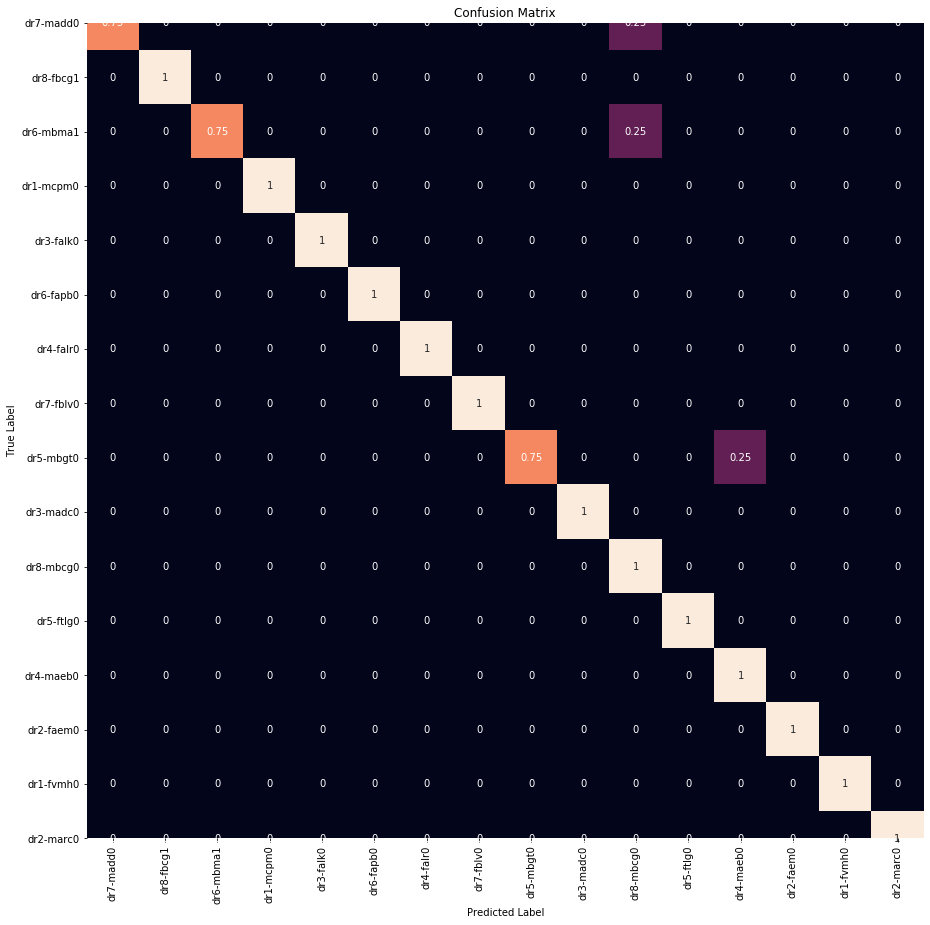

In [17]:
# Visualize Metrices

import matplotlib.pyplot as figure
import seaborn

from sklearn.metrics import confusion_matrix

uniqueSpeakers = speakers.unique()
cm = confusion_matrix(scores["test_speaker"], scores["result"], labels = uniqueSpeakers)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

figure.figure(figsize = (15,15))
seaborn.heatmap(cm, annot = True, cbar = False, xticklabels = uniqueSpeakers, yticklabels = uniqueSpeakers)
figure.ylabel('True Label')
figure.xlabel('Predicted Label')
figure.title('Confusion Matrix')